# BME-230B Spring 2019 HW 2 Question 
Andrew Davidson aedavids@ucsc.edu

supposedly it took Andrew and Yianni 3 days to write the louvain clustering algo. The inner loop is about 100 lines.

Given we only get 10 pts for the implementation and we are running out of time lets use the scanpy version for now

## <span style="color:red">TODO</span>
    - implement 2.a Louvain Clustering 
    
## <span style="color:red">TODO</span>
    - double check 2.b graphs when we split out by batch
    - notice the batch plot for 3 prime has 3 and 5?
    - I exploreData notebook I confirmed that all the three prime by 'method' are stacked on top of 5 prime. I assume that the batch col must be the same? should verify that are the same
    
- ref
    * [scanpy.tl.umap](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.tl.umap.html)
    * [scanpy.api.pp.neighbors](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.api.pp.neighbors.html?highlight=neighbors)
    * [scanpy.pl.umap](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.pl.umap.html#scanpy.pl.umap)
    * [scanpy.tl.louvain](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.tl.louvain.html#scanpy.tl.louvain)
    * [GSEAPY: Gene Set Enrichment Analysis in Python. pypi.org](https://pypi.org/project/gseapy/)
    * [GSEAPY: Gene Set Enrichment Analysis in Python gseapy.readthedocs.io](https://gseapy.readthedocs.io/en/latest/introduction.html)
    * [anndata](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html)
        + "uns" stands for unstructured data
        + "obs" are panda data frame observations 
        + "obsm key-indexed multi-dimensional observations
    * [Hypergeometric_distribution](https://en.wikipedia.org/wiki/Hypergeometric_distribution)
    * [Hypergeometric Tests
for Gene Lists](http://users.unimi.it/marray/2007/material/day4/Lecture7.pdf)

In [71]:
from euclid_knn import knnG
import gseapy as gp
import matplotlib.pyplot as plt
import numpy as np
import os

# scanpy louvain() returns slightly different results ever time kernal is restarted
# setting random seed does not make a differnce
# this side effect makes unit testing hard
#
# import random 
# random.seed(43) 

import pandas as pd
import scanpy.api as sc
import scanpy
print("scanpy.__version__:{}".format(scanpy.__version__))

import scipy.special
import scipy.stats as stats

scanpy.__version__:1.4.1


## 2.b. [5 pts] 
Turn in a UMAP plot of the combined dataset as you did in question #1, but
this time, color the cells by their Louvain cluster assignments determined for each cell
within each batch as a different color in each plot.

In [4]:
%%time
anndata = sc.read("PBMC.merged.h5ad")

# run our implementation of nearest neighboors and update anndata
knnG(anndata, n_neighbors=12)

emptying .uns...
CPU times: user 2min 19s, sys: 1.82 s, total: 2min 21s
Wall time: 2min 15s


In [7]:
%%time

# louvain argments suggested by Andrew durring office hrs
# resolution : float, None
# For the default flavor ('vtraag'), you can provide a resolution 
# (higher resolution means finding more and smaller clusters), 
# which defaults to 1.0. See “Time as a resolution parameter” in 
# [Lambiotte09].
# scanpy.tl.louvain(anndata, resolution=1)

#
# lovain parameters listed in homework
# flavor=’igraph’, directed=False, use_weights=True
scanpy.tl.louvain(anndata,
                  flavor='igraph', 
                  directed=False, 
                  use_weights=True)

CPU times: user 2.52 s, sys: 85.8 ms, total: 2.61 s
Wall time: 1.7 s


In [8]:
plt.figure(figsize=(10,10))
scanpy.tl.umap(anndata)

<Figure size 720x720 with 0 Axes>

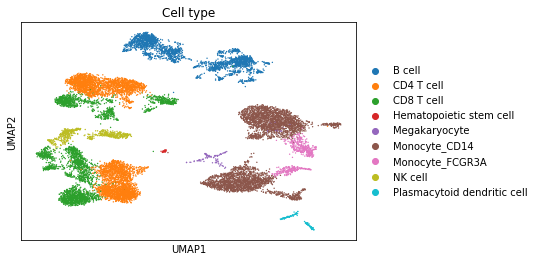

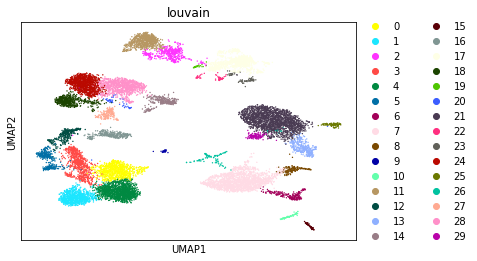

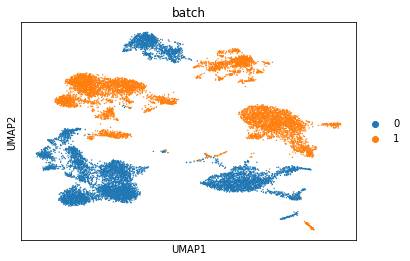

In [9]:
scanpy.pl.umap(anndata, color=['Cell type'])
scanpy.pl.umap(anndata, color=["louvain"])
scanpy.pl.umap(anndata, color=["batch"])

## <span style="color:red">AEDWIP TODO</span>

- after louvain split into  sets 3prime and 5prime
- create two plots batch vs cell type

### 3 and 5 prime cells clusters are different

In [10]:
prime3Rows = anndata.obs['Method'] == '10X_3prime'
prime5Rows = anndata.obs['Method'] == '10X_5prime'
print("prime3Rows.sum(): {}".format(prime3Rows.sum()))
print("prime5Rows.shape: {}".format(prime5Rows.sum()))

# save output created by running louvain on combined data set
louvainClustersSave =  anndata.obs.loc[:,['louvain']]
cellTypeSave = anndata.obs.loc[:, ['Cell type']]
batchSave = anndata.obs.loc[:, ['batch']]

# select the 3prime and 5prime data we want to plot
prime3Cluster = louvainClustersSave.loc[prime3Rows,:]
prime5Cluster = louvainClustersSave.loc[prime5Rows,:]

prime3CellType = anndata.obs.loc[prime3Rows,['Cell type']]
prime5CellType = anndata.obs.loc[prime5Rows,['Cell type']]

prime3Batch = anndata.obs.loc[prime3Rows,['batch']]
prime5Batch = anndata.obs.loc[prime5Rows,['batch']]

prime3Rows.sum(): 8098
prime5Rows.shape: 7378


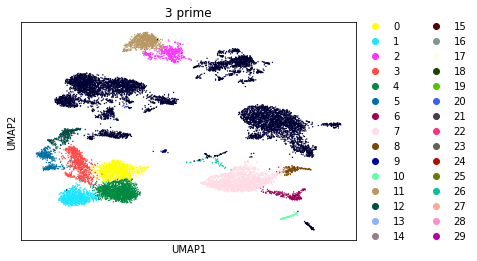

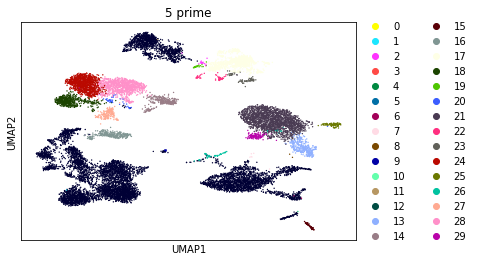

In [11]:
# plot 3 prime
anndata.obs['louvain'] = None # make sure there are not artifacts
anndata.obs.loc[:,['louvain']] = prime3Cluster
scanpy.pl.umap(anndata, color=["louvain"], title="3 prime")

# plot 5 prime
anndata.obs['louvain'] = None # make sure there are not artifacts
anndata.obs.loc[:,['louvain']] = prime5Cluster
scanpy.pl.umap(anndata, color=['louvain'], title="5 prime")

### cell typed differ between batchs

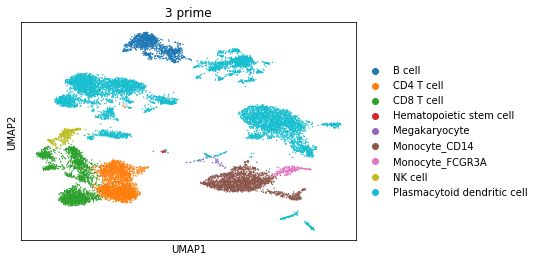

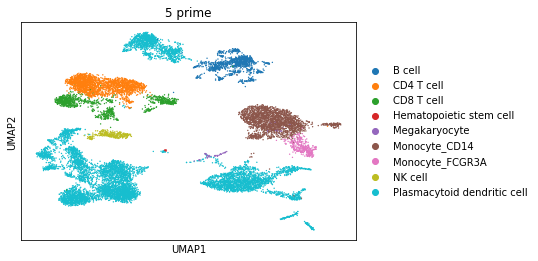

In [12]:
anndata.obs['louvain'] = None # make sure there are not artifacts
anndata.obs.loc[:,['louvain']] = prime3Cluster
anndata.obs['Cell type'] = None # remove artifacts
anndata.obs.loc[:,['Cell type']] = prime3CellType
scanpy.pl.umap(anndata, color=['Cell type'], title="3 prime")

anndata.obs['louvain'] = None # make sure there are not artifacts
anndata.obs.loc[:,['louvain']] = prime5Cluster
anndata.obs['Cell type'] = None # remove artifacts
anndata.obs.loc[:,['Cell type']] = prime5CellType
scanpy.pl.umap(anndata, color=['Cell type'], title="5 prime")

## <span style="color:red">Bug?</span>
looks like 3 prime has some 5 prime in it. test that 'batch' and 'method' cols agree

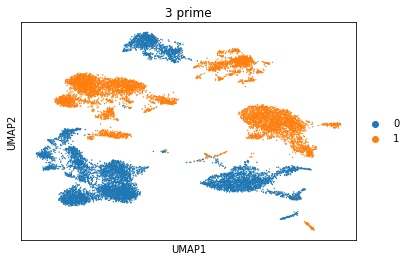

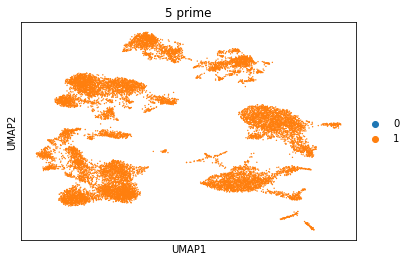

In [13]:
anndata.obs['louvain'] = None # make sure there are not artifacts
anndata.obs.loc[:,['louvain']] = prime3Cluster
anndata.obs['batch'] = None # remove artifacts
anndata.obs.loc[:,['batch']] = prime3Batch
scanpy.pl.umap(anndata, color=["batch"], title="3 prime")

anndata.obs['louvain'] = None # make sure there are not artifacts
anndata.obs.loc[:,['louvain']] = prime5Cluster
anndata.obs['batch'] = None # remove artifacts
anndata.obs.loc[:,['batch']] = prime5Batch
scanpy.pl.umap(anndata, color=['batch'], title="5 prime")

In [14]:
# restore original calculated cluster for combined data set
anndata.obs['louvain'] = None # make sure there are not artifacts
anndata.obs.loc[:,['louvain']] = louvainClustersSave

anndata.obs['Cell type'] = None # make sure there are not artifacts
anndata.obs.loc[:,['Cell type']] = cellTypeSave

anndata.obs['batch'] = None # make sure there are not artifacts
anndata.obs.loc[:,['batch']] = batchSave

## 2.c. [5 pts] 
Turn in a table that lists each cluster and its best-matching cell type
annotation. The table should contain the cluster number and its best matching cell-type
annotation based on the hypergeometric analysis.

In [15]:
def createCountsDict(anndata):
    '''
    assumes the data has been grouped by cluster id and cell type. 
    
    return:
        cellCountsByClusterId: 
            a dictionary of form d['cellType']['cellType'] == count
            
        cellTypesInClusters:
            a dictionary of form d['clusterId']{'cell type1', 'cell type2'}
    
    arguments:
        pandasGroupedData:
            example : df.groupby(['louvain', 'Cell type'])['louvain'].count()
            
        keys:
            example: grouped.groups.keys()
    '''
    df = anndata.obs.loc[:,['louvain', 'Cell type']]
    grouped = df.groupby(['louvain', 'Cell type'])
    pandasGroupedData=grouped['louvain'].count()
    keys=grouped.groups.keys()
    
    cellCountsByClusterId = {}
    cellTypesInClusters = {}
    for tup in keys:
        clusterId,cellType = tup
        if cellType not in cellCountsByClusterId :
            cellCountsByClusterId[cellType] = {}

        cellCountsByClusterId[cellType][clusterId] = pandasGroupedData[tup]
        
        if clusterId not in cellTypesInClusters:
            cellTypesInClusters[clusterId]= set()
        
        cellTypesInClusters[clusterId].add(cellType)
        
    return cellCountsByClusterId, cellTypesInClusters

In [16]:
cellCountsByClusterId, cellTypesInClusters = createCountsDict(anndata)

In [35]:
def cellCount(df, cellType):
    rows = (df.loc[:,['Cell type']] == cellType)
    n = rows.sum()
    # n is a pandas series
    return n.values[0]

In [36]:
# TODO: AEDWIP: define a class to store results. NO MAGIC NUMBERS
K_CELLTYPE = 0
K_P_Value = 1
K_X = 2
K_M = 3
K_n = 4
K_N = 5

def annotationProbsForCluster(anndata, cellTypesInClusters, clusterId):
    '''
    aedwip: todo:
    
    arguments:
    
    returns a list of tuples of following form
        (cellType, p, x, M, n, N)
        p = p-value
        x = number of cells in cluster of cellType
        M = populations size
        n = number of cell types in population
        N = number of cells in the cluster
        
    '''
    ret = []
    df = anndata.obs.loc[:,['louvain', 'Cell type']]
    M = df.count()[0] # size of population
#     print("M:{}".format(M))

    cellTypes = cellTypesInClusters[clusterId]
    for cellType in cellTypes:
        # count the number of cells in the cluster
        rows = df['louvain'] == clusterId
        N = sum(rows)

        totalCount = cellCount(df, cellType)
        n = totalCount # number of cell types in populations

        randomVariable = stats.hypergeom(M, n, N)
        x = cellCountsByClusterId[cellType][clusterId]
        pValue = 1.0 - randomVariable.cdf(x)
        
        ret.append( (cellType, pValue, x, M, n, N) )
        
    return ret
          
ret = annotationProbsForCluster(anndata, cellTypesInClusters, clusterId='0')

# print("\n\n************\nret:\n{}".format(ret))

In [45]:
def bestAnnotation(anndata, cellTypesInClusters):
    '''
    uses hypergeometric distribution to best-matching cell type annotation 
    
    returns:
        dataframe with a row for each cluster. the columns are 'cell type' and probablity
    '''
    clusterIds = cellTypesInClusters.keys()
    retDF = pd.DataFrame()
    
    for clusterId in clusterIds:
        stats = annotationProbsForCluster(anndata, cellTypesInClusters, clusterId)
#         print()
#         for s in stats:
#             print("s:\n{}".format(s))

        best = min(stats, key=lambda tup : tup[K_P_Value])
#         print("best:\n{}".format(best))

        bestDF = pd.DataFrame( data={'clusterId':int(clusterId),
                                     'Cell type':best[K_CELLTYPE],
                                     'p-value':best[K_PROB]}, 
                                index=[int(clusterId)] )
        retDF = retDF.append(bestDF)
    
    return retDF
        

In [46]:
retDF = bestAnnotation(anndata, cellTypesInClusters)  
retDF.sort_values(by=['clusterId'])

,clusterId,Cell type,p-value
0,0,CD4 T cell,1.607003e-11
1,1,CD8 T cell,0.000000e+00
2,2,B cell,2.065870e-11
3,3,CD8 T cell,3.827050e-11
4,4,CD4 T cell,0.000000e+00
5,5,CD8 T cell,6.087575e-12
6,6,Monocyte_CD14,0.000000e+00
7,7,Monocyte_CD14,0.000000e+00
8,8,Monocyte_FCGR3A,0.000000e+00
9,9,Hematopoietic stem cell,0.000000e+00


## 2.d. [5 pts] 
Turn in a list of top 5 pathways for each cluster in each dataset. You should
use the gene expression signature of each cluster to find an associated pathway. A gene
signature for a cluster represents the gene expression levels for a characteristic cell that is a
member of the cluster. Use the centroid 𝞵 i of the i th cluster as the signature. Compute the
centroids for each cluster in each dataset. You will next derive a gene-signature based
annotation for each cluster using these centroids. Use a list of Gene Ontology Biological
Process categories (provided in the Resources section at the top of this homework) and your
signatures to perform an all-against-all Gene Set Enrichment Analysis (GSEA). Turn in a table
that lists the top 5 pathways for each cluster

1. create a data frame we can use to select the cells in a given cluster
    a. we need the index value we can use to to get the cell's expression
    values from the numpy array anndata.obsm['X_pca'].shape

In [39]:
# numCells = anndata.obs['louvain'].size
# numCells

# numpyArrayIdx = [i for i in range(numCells)]
# d = {'louvain':anndata.obs['louvain'], 'npIdx':numpyArrayIdx }
# louvainDF = pd.DataFrame(data=d)
# louvainDF.head()

In [40]:
# cluster9Cells = louvainDF['louvain'] == '9'
# cluster9Cells.head()

In [41]:
# louvainDF.loc[cluster9Cells, :].count()

In [42]:
# louvainDF.loc[cluster9Cells, :].head()

In [43]:
# louvainDF.loc[cluster9Cells, ['npIdx']].head()

In [51]:
def getCellsIdxForCluster(anndata, clusterId):
    '''
    returns a list of indices that can be use to select the cells in 
    the cluster. the indices are int values that correspond to the
    rows in the numpy array anndata.obsm['X_pca']
    
    assumes clustering algorithym was run and results stored in
    anndata.obs['louvain']
    
    arguments:
        anndata
        clusterId: a string
    '''
    numCells = anndata.obs['louvain'].size

    numpyArrayIdx = [i for i in range(numCells)]
    d = {'louvain':anndata.obs['louvain'], 'npIdx':numpyArrayIdx }
    louvainDF = pd.DataFrame(data=d)
    
    clusterCells = louvainDF['louvain'] == clusterId
    ret = louvainDF.loc[clusterCells, ['npIdx']]
    return ret.values.flatten()
    
def testGetCellsIdxForCluster(anndata):
    ret = getCellsIdxForCluster(anndata,clusterId='9')
    print("AEDWIP len(ret):{}".format(len(ret)))
    # print("AEDWIP type(ret):{}".format(type(ret)))
    # print ("AEDWIP ret:\n{}".format(ret))
    # count varies slightly from kernal restart to kernal restart
    # sending random.seed() or using , random_state=42 argument to
    # scanpy.louvain() did not resolve this issue
    # assert 747 == len(ret)
    
testGetCellsIdxForCluster(anndata)

AEDWIP len(ret):26


In [52]:
# cellIndices = getCellsIdxForCluster(anndata,clusterId=9)
# print(type(cellIndices))
# print(cellIndices.shape)
# print(type(anndata.obsm['X_pca']))
# print(anndata.obsm['X_pca'].shape)
# print(anndata.obsm['X_pca'][cellIndices].shape)
# anndata.obsm['X_pca'][cellIndices]

In [53]:
def getGeneExpressionSignatureForCluster(anndata, clusterId):
    '''
    returns the centroid for cluster
    
    assumes:
        1) gene expression values stored in anndata.X
        
        2) clustering algorithym was run and results stored in
            anndata.obs['louvain']
    
    arguments:
        anndata
        clusterId: a string
    '''
    cellIndices = getCellsIdxForCluster(anndata ,clusterId)
    # pathways are in gene space not pca(50) space
    # anndata.obsm is a pandas data frame
    # data = anndata.obsm['X_pca'][cellIndices]
    # anndata.X is numpy array
    data = anndata.X[cellIndices, :]

    byColumns = 0
    return np.mean(data, axis=byColumns)

def testGetGeneExpressionSignatureForCluster(anndata):
    ret = getGeneExpressionSignatureForCluster(anndata, clusterId='9')
    # PCA 50
    #expFirst = np.array([-5.547451, 13.029236, -0.9483415, 
    #                    -5.8531246, -2.0250516])
    #expLast = np.array([-0.05719902, -0.16065401, 0.14730875, 
    #                    0.00936914, -0.06920523])
    
    # anndata.XC
    print("ret[0:5]:\n{}".format(ret[0:5]))
    print("ret[-5:]:\n{}".format(ret[-5:]))

    # count varies slightly from kernal restart to kernal restart
    # sending random.seed() or using , random_state=42 argument to
    # scanpy.louvain() did not resolve this issue
#     np.testing.assert_array_almost_equal(expFirst, ret[0:5])
#     np.testing.assert_array_almost_equal(expLast, ret[-5:])
    
testGetGeneExpressionSignatureForCluster(anndata)

ret[0:5]:
[-0.19640748 -0.37657496  0.07457613 -0.22251937 -0.13066345]
ret[-5:]:
[-0.06438085  0.00274978  0.2185609  -0.34335783 -0.18046874]


In [54]:
# # print( pd.unique(louvainDF.loc[:, ['louvain']]) )
# print( pd.unique(louvainDF['louvain']) )
# clusterSigs = {}
# for clusterId in pd.unique(louvainDF['louvain']) :
#     sig = getGeneExpressionSignatureForCluster(anndata, clusterId)
#     clusterSigs[clusterId] = sig

# #clusterSigs['3']

In [55]:
# rnkDf = pd.DataFrame(data={'gene':anndata.var['GeneName-0'],
#                            'score':clusterSigs['0']})
# pre_res = gp.prerank(rnk=rnkDf, gene_sets='GO_Biological_Process_2018',
#                      processes=4,
#                      permutation_num=100, # reduce number to speed up test
#                      outdir='./test/prerank_report_kegg',format='png')
                     

In [56]:
# type(pre_res)
# pre_res.figsize
# #pre_res.results


In [57]:
# goDF1 = pd.read_csv("./test/prerank_report_kegg/gseapy.prerank.gene_sets.report.csv")
# print(type(goDF1))
# goDF1.head()
# sort on nes, highier is best

In [58]:
# goDF1.sort('pval')
# goDF1.sort('pval')
# goDF1.sort_values('pval')

## <span style="color:red">2.d clean up</span>

In [59]:
# numCells = anndata.obs['louvain'].size
# #print(numCells)

# # numpyArrayIdx = [i for i in range(numCells)]
# d = {'louvain':anndata.obs['louvain'], 'npIdx':numpyArrayIdx }
# louvainDF = pd.DataFrame(data=d)

# # calculate 
# clusterSigs = {}
# for clusterId in pd.unique(louvainDF['louvain']) :
#     sig = getGeneExpressionSignatureForCluster(anndata, clusterId)
#     clusterSigs[clusterId] = sig

def calculateClusterSignatures(anndata):
    '''
    for each cluster calls getGeneExpressionSignatureForCluster()
    
    returns a dictionary. Key is the cluster id, value is its signature
    '''

    numCells = anndata.obs['louvain'].size
    numpyArrayIdx = [i for i in range(numCells)]
    d = {'louvain':anndata.obs['louvain'], 'npIdx':numpyArrayIdx }
    louvainDF = pd.DataFrame(data=d)
    
    clusterSigs = {}
    for clusterId in pd.unique(louvainDF['louvain']) :
        sig = getGeneExpressionSignatureForCluster(anndata, clusterId)
        clusterSigs[clusterId] = sig
    
    return clusterSigs

clusterSigs = calculateClusterSignatures(anndata)

In [60]:
# rnkDf = pd.DataFrame(data={'gene':anndata.var['GeneName-0'],
#                            'score':clusterSigs['0']})
# pre_res = gp.prerank(rnk=rnkDf, gene_sets='GO_Biological_Process_2018',
#                      processes=4,
#                      permutation_num=100, # reduce number to speed up test
#                      outdir='./test/prerank_report_kegg',format='png')


In [112]:
def rankPathWaysForCluster(anndata, clusterSigs, clusterId):
    '''
    aedwip
        # to speed up debugging do not run if results have already been 
    # calculated
    
    returns a tuple (cvsPath, preRes)
        if cvsPath exists preRes == None
    '''
    rnkDf = pd.DataFrame(data={'gene':anndata.var['GeneName-0'],
                               'score':clusterSigs[clusterId]})
    
    base = './gseapy.out/prerank_report_GO_Biological_Process_2018_clusterId-' 
    path = base + clusterId
    #print("path:{}".format(path))
    
    # path to output from previous run
    csvPath = path + "/" + 'gseapy.prerank.gene_sets.report.csv'
    #print("cvsPath:{}".format(csvPath))
    
    # to speed up debugging do not run if results have already been 
    # calculated
    ret = None
    exists = os.path.isfile(csvPath)
    if exists:
        # gseapy.gsea.Prerank
        # type(ret):<class 'gseapy.gsea.Prerank'>
        #ret.outdir = csvPath 
        ret = (csvPath, None)
    else:
        preRes = gp.prerank(rnk=rnkDf, 
                         gene_sets='GO_Biological_Process_2018',
                         processes=4,
                         permutation_num=100, # reduce number to speed up test
                         outdir=path,format='png')
        ret = (csvPath, preRes)
        
    #print("type(ret):{}".format(type(ret)))
    return ret

In [101]:
%%time
csvPath, preRes = rankPathWaysForCluster(anndata, 
                                         clusterSigs, 
                                         clusterId='0')
# print(type(goDF1))
# goDF1.head()
#print(type(preRes))

path:./gseapy.out/prerank_report_GO_Biological_Process_2018_clusterId-0
cvsPath:./gseapy.out/prerank_report_GO_Biological_Process_2018_clusterId-0/gseapy.prerank.gene_sets.report.csv
CPU times: user 3.9 ms, sys: 1.76 ms, total: 5.66 ms
Wall time: 5.42 ms


In [102]:
#path:
#./gseapy.out/prerank_report_GO_Biological_Process_2018_clusterId-0
#cvsPath:
#./gseapy.out/prerank_report_GO_Biological_Process_2018_clusterId-0/gseapy.prerank.gene_sets.report.csv
# './gseapy.out/prerank_report_GO_Biological_Process_2018_clusterId-0'
#preRes.outdir

In [104]:
# goDF = pd.read_csv(preRes.outdir + '/gseapy.prerank.gene_sets.report.csv')
# goDF = pd.read_csv(csvPath)
# goDF.head()
#sort on nes, highier is best

,Term,es,nes,pval,fdr,geneset_size,matched_size,genes
0,antigen processing and presentation of peptide...,-0.785178,-2.098063,0.0,0.0,99,20,"LAG3,FCGR2B,HLA-DOA,HLA-DOB,AP1S2,HLA-DQA2,HLA..."
1,neutrophil mediated immunity (GO:0002446),-0.646935,-2.326440,0.0,0.0,488,95,"ANXA2,S100A11,KRT1,CTSA,PGRMC1,S100P,CLEC5A,HS..."
2,neutrophil degranulation (GO:0043312),-0.649635,-2.275968,0.0,0.0,480,94,"ANXA2,S100A11,KRT1,CTSA,PGRMC1,S100P,CLEC5A,HS..."
3,neutrophil activation involved in immune respo...,-0.648430,-2.373607,0.0,0.0,484,96,"ANXA2,S100A11,KRT1,CTSA,PGRMC1,S100P,CLEC5A,HS..."
4,antigen processing and presentation of exogeno...,-0.779604,-2.133056,0.0,0.0,98,19,"LAG3,FCGR2B,HLA-DOA,HLA-DOB,AP1S2,HLA-DQA2,HLA..."


In [65]:
#goDF.sort_values(by='nes', ascending=False).head()


,Term,es,nes,pval,fdr,geneset_size,matched_size,genes
53,positive regulation of protein kinase B signal...,0.530869,1.651646,0.041667,0.504165,128,16,"ITGB1,TRAT1,GATA3,TXN,NRG2,AKR1C3,ERBB2,GAS6,T..."
20,tumor necrosis factor-mediated signaling pathw...,0.521377,1.635686,0.000000,0.280092,124,23,"LTB,TNFRSF4,CD40LG,TNFRSF18,BIRC3,LIMS1,EDARAD..."
18,T cell activation (GO:0042110),0.525291,1.631666,0.000000,0.190463,89,18,"CD3D,CD2,TNFRSF4,CD3E,FOXP3,ZAP70,CD7,TREML2,I..."
15,regulation of protein kinase B signaling (GO:0...,0.530380,1.620295,0.000000,0.156851,164,19,"ITGB1,TRAT1,GATA3,PPP2R5C,TXN,NRG2,SLC9A3R1,AK..."
37,regulation of immune response (GO:0050776),0.324933,1.443890,0.000000,0.405573,252,112,"TRAC,ITGB1,CD3D,KLRB1,CD40LG,TRBC1,NPDC1,CD3E,..."


In [66]:
#goDF.sort_values(by='nes', ascending=False).iloc[0:5, [0, 2]]


,Term,nes
53,positive regulation of protein kinase B signal...,1.651646
20,tumor necrosis factor-mediated signaling pathw...,1.635686
18,T cell activation (GO:0042110),1.631666
15,regulation of protein kinase B signaling (GO:0...,1.620295
37,regulation of immune response (GO:0050776),1.443890


In [125]:
def rankPathWays(anndata, clusterSigs, topN=5):
    '''
    aedwip
    '''
    retDF = pd.DataFrame()
    for clusterId in clusterSigs.keys():
        csvPath, preRes = rankPathWaysForCluster(anndata, 
                                         clusterSigs, 
                                         clusterId)
        df = pd.read_csv(csvPath)
        df2 = df.sort_values(by='nes', ascending=False)
        df3 = df2.iloc[0:topN, [0, 2]]
        numRows = df3.shape[0]
        cid = [int(clusterId) for j in range(numRows)]
        df3['cluster id'] = cid
        retDF = retDF.append(df3)
        
    retDF = retDF.sort_values(by='cluster id')
    return retDF
        

In [126]:
%%time
retDF = rankPathWays(anndata, clusterSigs, topN=5)

CPU times: user 12.7 s, sys: 20.4 ms, total: 12.7 s
Wall time: 12.7 s


In [127]:
retDF[['Term', 'nes', 'cluster id']]

,Term,nes,cluster id
17,regulation of immune response (GO:0050776),1.539449,0
21,regulation of protein kinase B signaling (GO:0...,1.795614,0
15,tumor necrosis factor-mediated signaling pathw...,1.703791,0
13,T cell activation (GO:0042110),1.649807,0
16,positive regulation of protein kinase B signal...,1.585081,0
6,T cell activation (GO:0042110),2.351197,1
8,enzyme linked receptor protein signaling pathw...,2.055423,1
82,"complement activation, classical pathway (GO:0...",1.408401,1
78,regulation of immune response (GO:0050776),1.386783,1
49,transmembrane receptor protein tyrosine kinase...,1.589282,1


In [107]:
fooDF = pd.DataFrame(data={'a':[1, 2, 3, 4], 'b':['t', 'u', 'v', 'w']})
fooDF['clusterId'] = [1 for i in range(fooDF.shape[0])]
fooDF

,a,b,clusterId
0,1,t,1
1,2,u,1
2,3,v,1
3,4,w,1
